In [1]:
from solver import solve, solve_stp
from pprint import pprint

from random import uniform, randint

from matplotlib import pyplot as plt

In [2]:
def generate_problem(range_min, range_max, f, variables, constraint_probability, min_intervals, max_intervals, ratio=0.05):
    X = [0] + [randint(0, 100) for _ in range(variables-1)]    
    T_all = []

    visited_edges = set()    

    for j in range(variables):
        T = {
            'i': 0,
            'j': j,
            'intervals': [(-100, 100)],
        }
        T_all += [T]
        
    for i in range(1, variables):
        for j in range(i+1, variables):
            if uniform(0, 1) < constraint_probability:
                T = {}
                diff = X[j] - X[i]
                T['i'] = i
                T['j'] = j
                T['intervals'] = []
                for _ in range(randint(min_intervals, max_intervals)):
                    tupl = f(ratio=ratio)
                    T['intervals'].append( tupl )
                T_all.append(T)

    return T_all

def print_problem(T):
    print(max(cr['j'] for cr in T) + 1, len(T))
    for Tij in T:
        print(Tij['i'], Tij['j'], len(Tij['intervals']), end=' ')
        for a, b in Tij['intervals']:
            print(a, b, end=' ')
        print()
        
def pick_first(constraints):
    return constraints[0]

def pick_least_intervals(constraints):
    sol_ctr = constraints[0]
    num = len(sol_ctr['intervals'])
    for ctr in constraints[1:]:
        if len(ctr['intervals']) < num:
            sol_ctr = ctr
            num = len(ctr['intervals'])
    
    return sol_ctr


In [96]:
# what to graph:
# 1) graph how many have a consistent solution
# 2) dead end cuts
# 3) how likely is Path Consistency and/or Arc Consistency to find correct solution??
# 4) ^ continuation: does it find correct minimal network

In [97]:
def try_heuristic(runs, num_vars, constr_prob, max_intervals):
    consistent = 0
    
    dead = 0
    total = 0

    # least intervals heur.
    dead_li = 0
    total_li = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(num_vars, constr_prob, max_intervals)

        sol = solve(num_vars, T, pick_constraint=pick_first)
        if sol['consistent'] > 0:
            consistent += 1
        dead += sol['dead']
        total += sol['total']

        sol_li = solve(num_vars, T, pick_constraint=pick_least_intervals)
        dead_li += sol_li['dead']
        total_li += sol_li['total']


    fig, axs = plt.subplots(2)
    axs[0].bar(
        ['consistent', 'inconsistent'],
        [consistent, runs - consistent],
    )

    axs[1].bar(
        ['dead ends', 'total ends', 'dead ends LI', 'total ends LI'],
        [dead / runs, total / runs, dead_li / runs, total_li / runs],
    )

# SIMPLE Problem Set

## SIMPLE, with varying interval/domain ratio (i.e. f function)

id ratio 0.1
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 id ratio 0.2
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 id ratio 0.3
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0

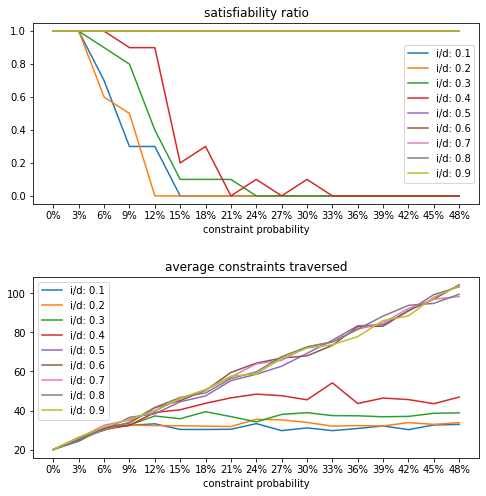

In [103]:
def f(range_left=-100, range_right=100, ratio=0.5):
    domain_size = range_right - range_left
    step = ratio*domain_size
    a = randint(0, int(1/ratio) - 1)
    return range_left + a*step, range_left + (a+1)*step

# percent satisfiable over constraint probability on everything else fixed
def try_sat(runs, num_vars, constr_prob, min_intervals, max_intervals, interval_domain_ratio):
    consistent = 0
    calls = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(-100, 100, 
                             f, 
                             num_vars, constr_prob, min_intervals, max_intervals,
                             ratio=interval_domain_ratio)
        # WARNING: solve_stp is called here (if copy paste be careful)
        sol = solve_stp(num_vars, T)
        if sol['consistent'] > 0:
            consistent += 1
        calls += sol['total']
    
    return (consistent / runs, calls / runs) 


fig, axs = plt.subplots(2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4)
axs[0].set_xlabel('constraint probability')
axs[0].set_title('satisfiability ratio')
axs[1].set_xlabel('constraint probability')
axs[1].set_title('average constraints traversed')

for idr in range(1, 10, 1):
    interval_domain_ratio = idr/10
    
    print('id ratio', interval_domain_ratio)
    x_axis = []
    graph = []
    calls = []
    for prob in range(0, 50, 3):
        x_axis.append(f'{prob}%')
        sat, n_calls = try_sat(
            runs=10,
            num_vars=20,
            constr_prob=prob/100,
            min_intervals=1,
            max_intervals=1,
            interval_domain_ratio=interval_domain_ratio,
        )
        graph.append(sat)
        calls.append(n_calls)
        
    axs[0].plot(x_axis, graph, label=f'i/d: {interval_domain_ratio}')
    axs[1].plot(x_axis, calls, label=f'i/d: {interval_domain_ratio}')
    
axs[0].legend()
axs[1].legend()

# BINARY Problem Set

id ratio 0.1
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

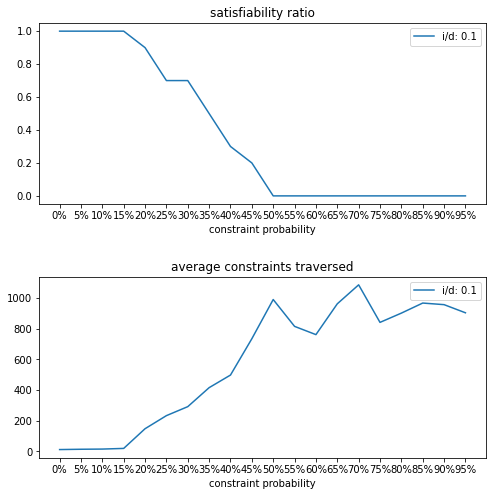

In [5]:
def f(range_left=-100, range_right=100, ratio=0.5):
    domain_size = range_right - range_left
    step = ratio*domain_size
    a = randint(0, int(1/ratio) - 1)
    return range_left + a*step, range_left + (a+1)*step

# percent satisfiable over constraint probability on everything else fixed
def try_sat(runs, num_vars, constr_prob, interval_domain_ratio):
    consistent = 0
    calls = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(-100, 100, 
                             f, 
                             num_vars, constr_prob, 2, 2,
                             ratio=interval_domain_ratio)
        
        
        sol = solve(num_vars, T, pick_constraint=pick_least_intervals, break_on_sat=True)[0]
        if sol['consistent'] > 0:
            consistent += 1
        calls += sol['total']
    
    return (consistent / runs, calls / runs) 


fig, axs = plt.subplots(2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4)
axs[0].set_xlabel('constraint probability')
axs[0].set_title('satisfiability ratio')
axs[1].set_xlabel('constraint probability')
axs[1].set_title('average constraints traversed')

for idr in range(1, 2, 1):
    interval_domain_ratio = idr/10
    
    print('id ratio', interval_domain_ratio)
    x_axis = []
    graph = []
    calls = []
    for prob in range(0, 100, 5):
        x_axis.append(f'{prob}%')
        sat, n_calls = try_sat(
            runs=10,
            num_vars=10,
            constr_prob=prob/100,
            interval_domain_ratio=interval_domain_ratio,
        )
        graph.append(sat)
        calls.append(n_calls)
        
    axs[0].plot(x_axis, graph, label=f'i/d: {interval_domain_ratio}')
    axs[1].plot(x_axis, calls, label=f'i/d: {interval_domain_ratio}')
    
axs[0].legend()
axs[1].legend()

## stuff to make sure w.r.t
# -> make sure that break_on_sat works correctly
# -> try different pick_constraint's, vary probability, vary interval_domain_ratio